In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import datetime as dt
import requests

# PULLING DATA

In [2]:
email = 'youremail'
product_type = 'indices'
time_frame = 'Weekly'

from_date = '01/01/1970'
to_date = dt.datetime.now().strftime('%m/%d/%Y')
name = 'SPX'
params = {
    "email": email,
    "type": "historical_data",
    "product": product_type,
    "from_date": from_date,
    "to_date": to_date,
    "time_frame": time_frame,
    "symbol": name,
    "country":'united states'
}

response = requests.get("http://api.scraperlink.com/investpy/", params=params)
data = response.json()
df0 = pd.DataFrame(data['data'])

# CLEANING DATA

In [3]:
df = df0[['rowDateTimestamp','last_close', 'last_open', 'last_max', 'last_min']].copy()

In [4]:
for x in range(len(df.columns)-1):
    df[df.columns[x+1]] = df[df.columns[x+1]].replace(',','',regex = True)
    df[df.columns[x+1]] = df[df.columns[x+1]].astype(float)
df['Date'] = pd.to_datetime(df['rowDateTimestamp']).dt.date
df.drop('rowDateTimestamp', axis = 1, inplace = True)

In [5]:
df = df.sort_values(by = 'Date', ascending = True).reset_index(drop = True)

In [6]:
#df.to_pickle("./SP500Data.pkl")

In [73]:
df = pd.read_pickle('SP500Data.pkl')

# PREPARING DATA

In [74]:
# 73 OIL CRISIS
# 5 Years After 1973 January 1
data_1973 = df[(df['Date']>=pd.Timestamp('01/01/1973').date()) & (df['Date']<=pd.Timestamp('01/01/1978').date())].reset_index(drop = True).copy()

# 2000 Dot Com
# 5 Years After 2000 April 1
data_2000 = df[(df['Date']>pd.Timestamp('04/01/2000').date()) & (df['Date']<pd.Timestamp('04/01/2005').date())].reset_index(drop = True).copy()

# 2007 GFC
# 5 Years After 2007 October 1 
data_2007 = df[(df['Date']>pd.Timestamp('10/01/2007').date()) & (df['Date']<pd.Timestamp('10/01/2012').date())].reset_index(drop = True).copy()

# 2022 Downturn (Continued Bear?)
# 5 Years After 2022 January 1
data_2022 = df[(df['Date']>pd.Timestamp('01/01/2022').date()) & (df['Date']<pd.Timestamp('01/01/2027').date())].reset_index(drop = True).copy()


In [75]:
# Anchoring the very first week's mean price and calculating cumulative returns

for i, df in enumerate([data_1973, data_2000, data_2007, data_2022]):
    df['Week'] = (((df['Date'] - df['Date'].shift(1))/7).dt.days).cumsum()
    df['Price'] = (df['last_close']*2 + df['last_open'] + df['last_max'] + df['last_min'])/5
    df.drop(['last_close', 'last_open', 'last_max', 'last_min', 'Date'], axis=1, inplace=True)
    df['Price'] = ((df['Price']/df['Price'].iloc[0])-1)
    df.iloc[0, 0] = 0
    df.set_index('Week', inplace=True)
    df.columns = ['Price' + str(i)]


In [80]:
# merging all
df = pd.concat([data_1973, data_2000,data_2007, data_2022], axis = 1)
df.columns = ['Oil','Dotcom','GFC','Now']

# VISUALIZING THE DATA

<AxesSubplot:title={'center':'S&P 500 cumulative returns for recoveries longer than 1 year'}, xlabel='Week', ylabel='Cum. Returns'>

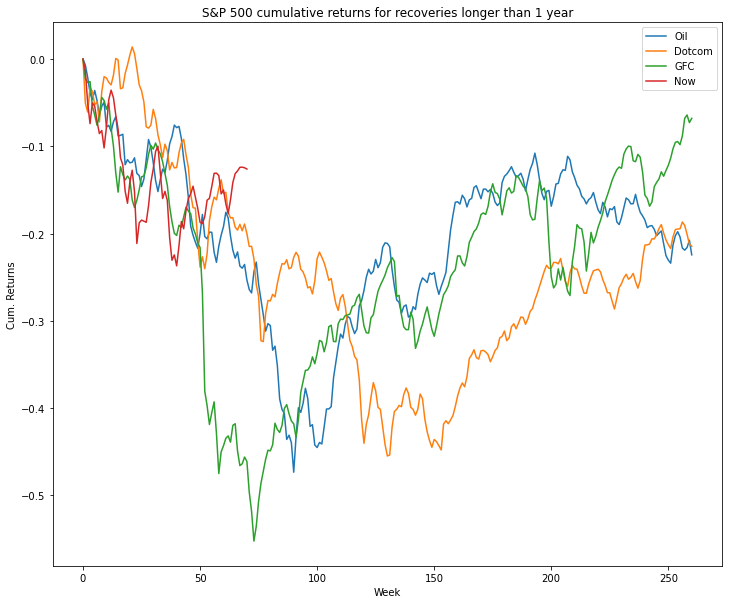

In [82]:
# GENERAL PLOT
fig, ax = plt.subplots(figsize = (12,10))
plt.title('S&P 500 cumulative returns for recoveries longer than 1 year')
plt.xlabel('Weeks')
plt.ylabel('Cum. Returns')
df.plot(kind = 'line', ax = ax)

In [83]:
# PLOT WITH SLIDERS
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
cf.go_offline()
import chart_studio.plotly as py
df.iplot(kind = 'line', yTitle = 'Cum. Returns', xTitle = 'Weeks', title = 'S&P 500 cumulative returns for recoveries longer than 1 year')

In [90]:
# New Adjusted Data set = only up to current
adj_df = df.iloc[:int(df[df['Now'].notnull()].index[-1])].copy()

<IPython.core.display.Javascript object>


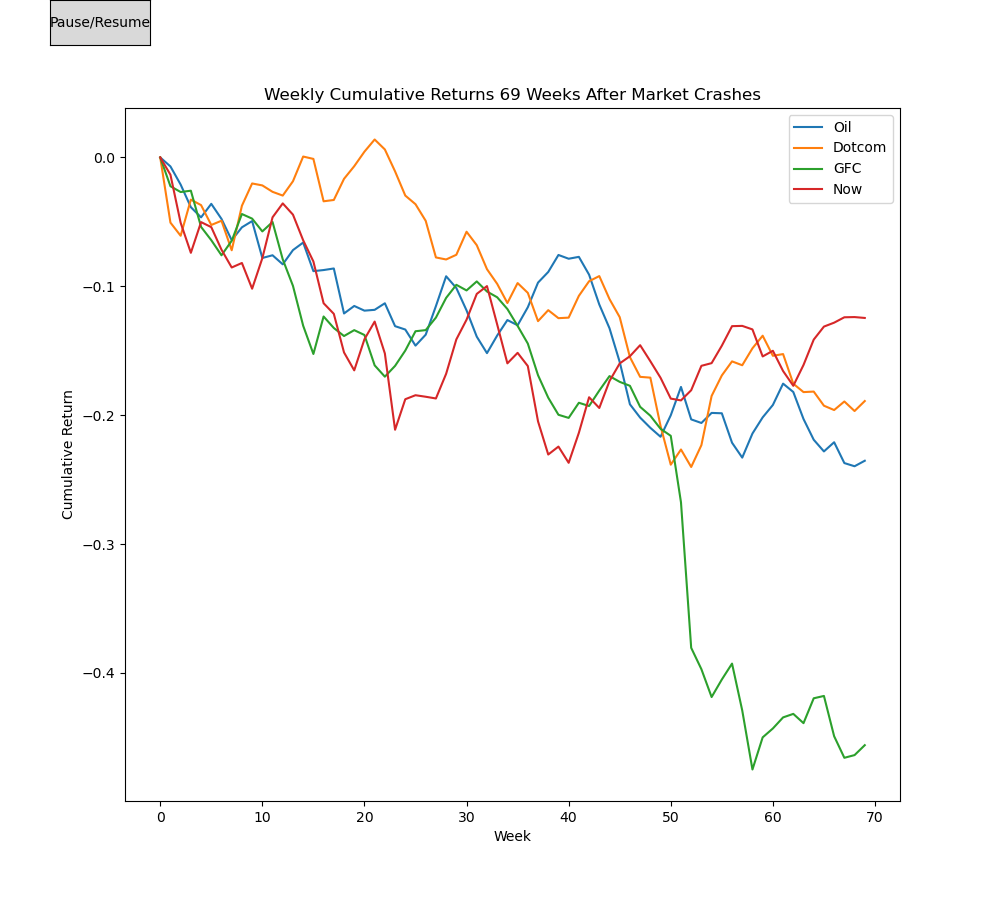

In [95]:
%matplotlib notebook
from matplotlib.widgets import Button
fig, ax = plt.subplots(figsize=(10, 9))
plt.title ('Weekly Cumulative Returns '+ str(int(adj_df.index[-1]))+' Weeks After Market Crashes')
ax.set_xlabel('Week')
ax.set_ylabel('Cumulative Return')
lines = []
for i in range(adj_df.shape[1]):
    line, = ax.plot([], [], label=adj_df.columns[i])
    lines.append(line)
ax.legend()

paused = False

def animate(i):
    global paused
    if not paused:
        for j in range(adj_df.shape[1]):
            lines[j].set_data(adj_df.iloc[:i+1, j].index, adj_df.iloc[:i+1, j])
        ax.relim()  
        ax.autoscale()  
    return lines

def on_pause_button_clicked(event):
    global paused
    paused = not paused

pause_button_ax = plt.axes([0.05, 0.95, 0.1, 0.05])
pause_button = Button(pause_button_ax, 'Pause/Resume')
pause_button.on_clicked(on_pause_button_clicked)

ani = FuncAnimation(fig, animate, frames=adj_df.shape[0], interval=400, repeat=False)
#ani.save('SP500 '+str(int(adj_df.index[-1]))+' Weeks After Market Crashes.gif', writer = 'pillow')
plt.show()

<IPython.core.display.Javascript object>


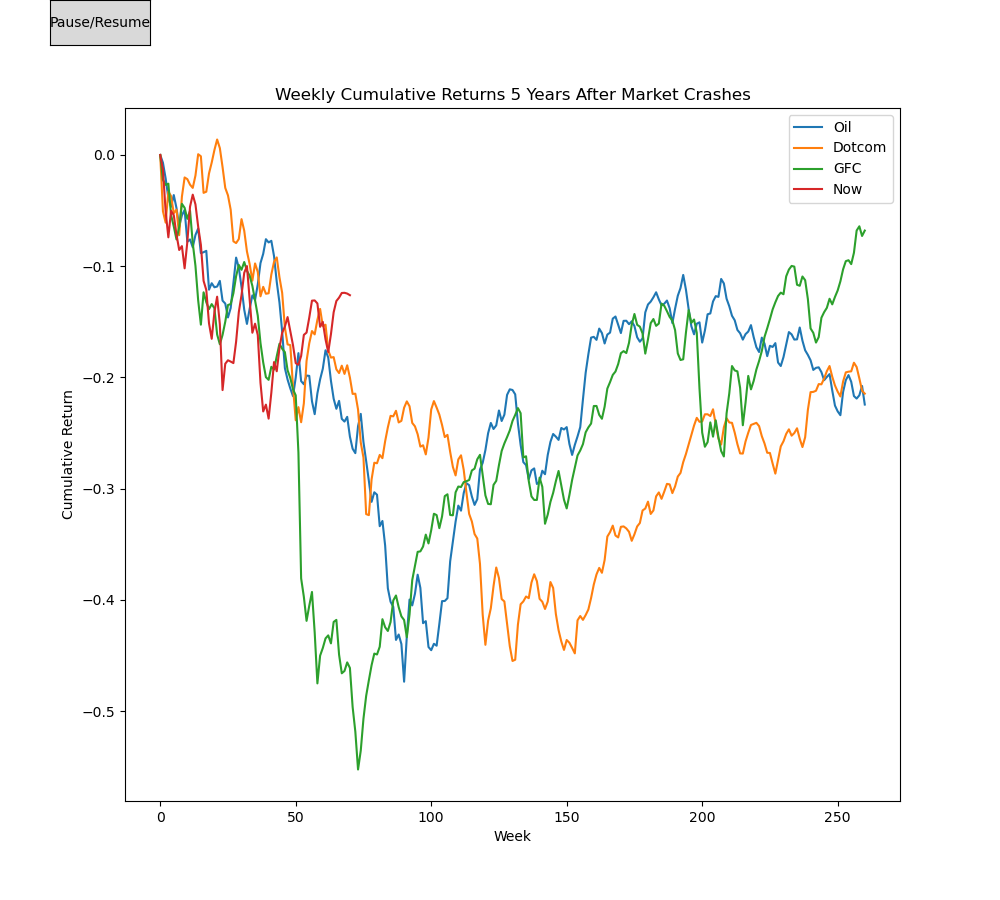

In [96]:
fig, ax = plt.subplots(figsize=(10, 9))
plt.title ('Weekly Cumulative Returns 5 Years After Market Crashes')
ax.set_xlabel('Week')
ax.set_ylabel('Cumulative Return')
lines = []
for i in range(df.shape[1]):
    line, = ax.plot([], [], label=df.columns[i])
    lines.append(line)
ax.legend()

paused = False

def animate(i):
    global paused
    if not paused:
        for j in range(df.shape[1]):
            lines[j].set_data(df.iloc[:i+1, j].index, df.iloc[:i+1, j])
        ax.relim()  # Recompute the data limits
        ax.autoscale()  # Automatically adjust the axis limits
    return lines

def on_pause_button_clicked(event):
    global paused
    paused = not paused

pause_button_ax = plt.axes([0.05, 0.95, 0.1, 0.05])
pause_button = Button(pause_button_ax, 'Pause/Resume')
pause_button.on_clicked(on_pause_button_clicked)

ani = FuncAnimation(fig, animate, frames=df.shape[0], interval=100, repeat=False)
#ani.save('SP500 5 Years After Market Crashes.gif', writer = 'pillow')
plt.show()